<a href="https://colab.research.google.com/github/AbhilashPoshanagari/Causal_Alpha/blob/main/notebooks/Rupesh_Capstone_BaselineModels_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Required Libraries

In [1]:
!pip -q install yfinance

## Import Required Libraries

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

## Load Data

In [3]:
# Download NIFTY50 data
ticker = "^NSEI"  # NIFTY50 index
df = yf.download(ticker, start="2010-01-01", end="2025-03-01")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


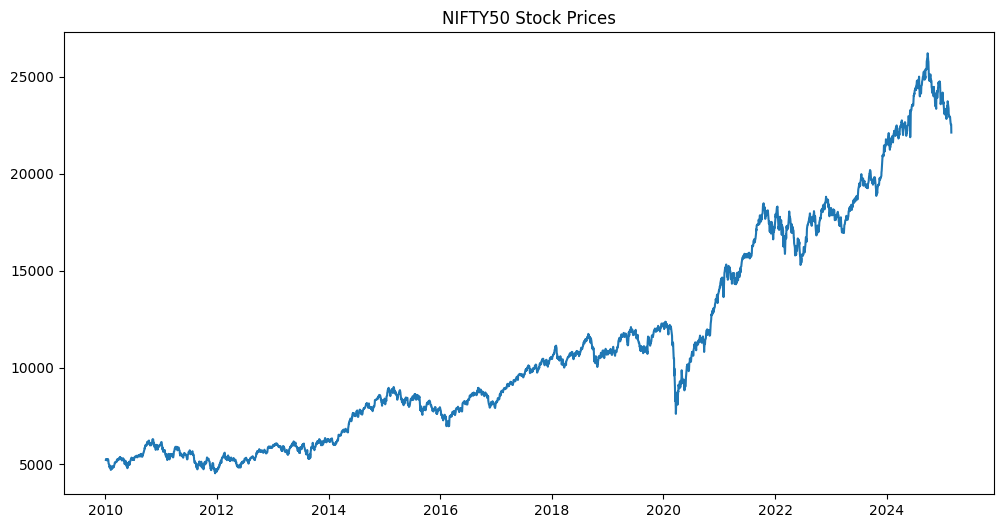

In [4]:
# Use only the closing price
data = df[['Close']].dropna()
plt.figure(figsize=(12, 6))
plt.plot(data)
plt.title("NIFTY50 Stock Prices")
plt.show()

In [5]:
data.shape

(3722, 1)

In [6]:
# Save data to csv
data.to_csv("nifty50.csv")

In [7]:
# Use last 100 days data for Test & remaining for training
data_last_100 = data.iloc[-100:]
data = data.iloc[:-100]
data.shape, data_last_100.shape

((3622, 1), (100, 1))

In [8]:
data.tail() , data_last_100.head()

(Price              Close
 Ticker             ^NSEI
 Date                    
 2024-09-30  25810.849609
 2024-10-01  25796.900391
 2024-10-03  25250.099609
 2024-10-04  25014.599609
 2024-10-07  24795.750000,
 Price              Close
 Ticker             ^NSEI
 Date                    
 2024-10-08  25013.150391
 2024-10-09  24981.949219
 2024-10-10  24998.449219
 2024-10-11  24964.250000
 2024-10-14  25127.949219)

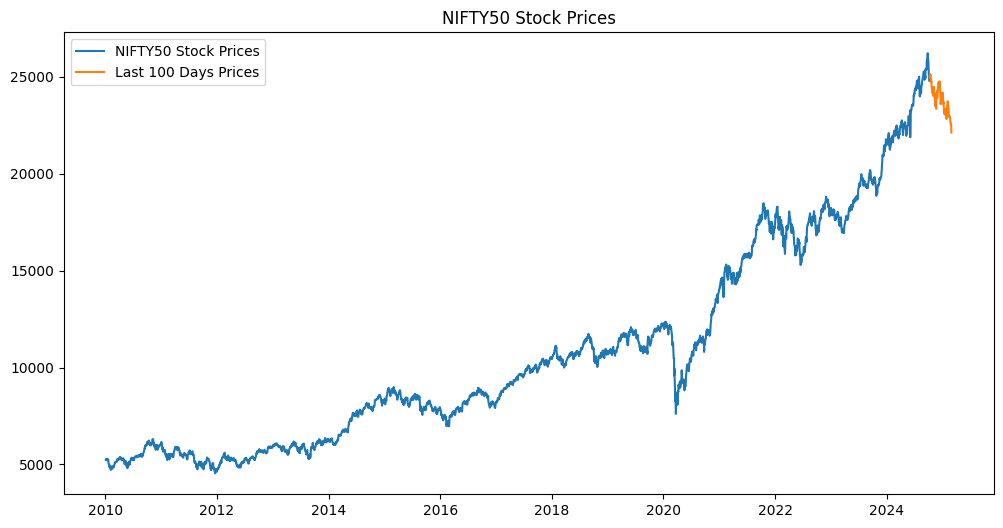

In [9]:
# plot data & data_last_100
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close'], label="NIFTY50 Stock Prices")
plt.plot(data_last_100.index, data_last_100['Close'], label="Last 100 Days Prices")
plt.title("NIFTY50 Stock Prices")
plt.legend()
plt.show()

## Baseline Models

### ARIMA Model

In [10]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings

warnings.filterwarnings("ignore")

 Determine optimum differencing order (d) using ADF test

In [11]:
# ADF Test Function
def adf_test(series):
    result = adfuller(series)
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    return result[1] > 0.05  # If p > 0.05, data is non-stationary

# Check stationarity for different differencing levels
diff_data = data['Close'].copy()
d = 0
while adf_test(diff_data):
    d += 1
    diff_data = diff_data.diff().dropna()

print(f"Optimal Differencing Order (d): {d}")


ADF Statistic: 1.6667932057766932
p-value: 0.998044746959178
ADF Statistic: -11.192073700048532
p-value: 2.355341299121493e-20
Optimal Differencing Order (d): 1


Find p (AR order) & q (MA order) using PACF & ACF

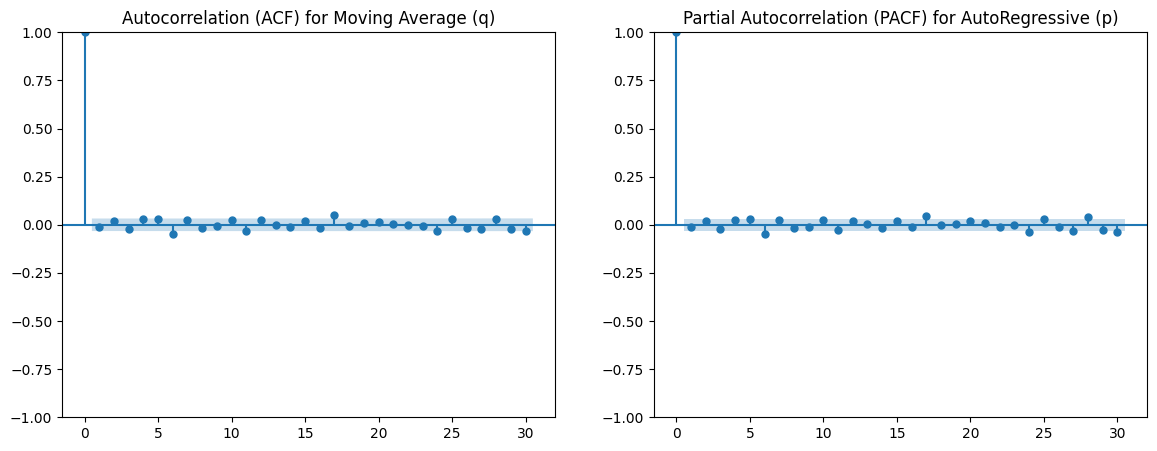

In [12]:
# Plot ACF & PACF
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ACF Plot (for q)
plot_acf(diff_data, ax=axes[0], lags=30)
axes[0].set_title("Autocorrelation (ACF) for Moving Average (q)")

# PACF Plot (for p)
plot_pacf(diff_data, ax=axes[1], lags=30)
axes[1].set_title("Partial Autocorrelation (PACF) for AutoRegressive (p)")

plt.show()


Using Grid Search to find (p,d,q)

In [13]:
import itertools
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Possible values for p, d, q
p_range = range(0, 5)
d_range = [d]  # From ADF test
q_range = range(0, 5)

# Grid search
best_aic = float("inf")
best_order = None
best_model = None

for p, d, q in itertools.product(p_range, d_range, q_range):
    try:
        model = ARIMA(data['Close'], order=(p, d, q))
        result = model.fit()
        if result.aic < best_aic:
            best_aic = result.aic
            best_order = (p, d, q)
            best_model = result
    except:
        continue

print(f"Best ARIMA Order: {best_order} with AIC: {best_aic}")


Best ARIMA Order: (2, 1, 3) with AIC: 44617.274463053254


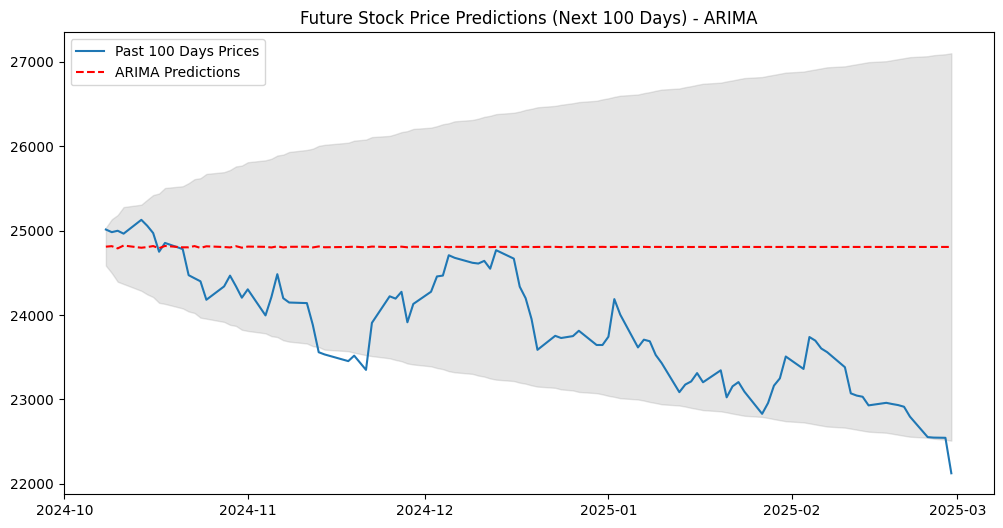

         Date  Predicted_Close   Lower_Bound   Upper_Bound
0  2024-10-08     24810.039051  24584.692997  25035.385105
1  2024-10-09     24815.901220  24497.264945  25134.537495
2  2024-10-10     24789.739386  24394.348195  25185.130577
3  2024-10-11     24823.264416  24367.458652  25279.070181
4  2024-10-14     24797.307068  24286.932233  25307.681903
..        ...              ...           ...           ...
95 2025-02-21     24806.875091  22558.080967  27055.669215
96 2025-02-24     24806.437943  22545.953584  27066.922301
97 2025-02-25     24806.683964  22534.569668  27078.798261
98 2025-02-27     24806.716995  22523.038546  27090.395443
99 2025-02-28     24806.443619  22511.249450  27101.637788

[100 rows x 4 columns]


In [14]:
# Forecast the next 100 days using the best ARIMA model
future_steps = 100
forecast_result = best_model.get_forecast(steps=future_steps)
forecast_values = forecast_result.predicted_mean
forecast_ci = forecast_result.conf_int()

# Generate future dates
# future_dates = pd.date_range(start=data.index[-1], periods=future_steps + 1)[1:]
future_dates = data_last_100.index

# Convert forecast results to DataFrame
forecast_df = pd.DataFrame({
    "Date": future_dates,
    "Predicted_Close": forecast_values.values,
    "Lower_Bound": forecast_ci.iloc[:, 0].values,
    "Upper_Bound": forecast_ci.iloc[:, 1].values
})

# Plot Historical vs Forecasted Prices
plt.figure(figsize=(12, 6))
# plt.plot(df.index[-100:], df['Close'].values[-100:], label="Past 100 Days Prices")
plt.plot(data_last_100.index, data_last_100.values, label="Past 100 Days Prices")
plt.plot(future_dates, forecast_values, label="ARIMA Predictions", linestyle="dashed", color='red')
plt.fill_between(future_dates, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='gray', alpha=0.2)
plt.title("Future Stock Price Predictions (Next 100 Days) - ARIMA")
plt.legend()
plt.show()

# Print Predicted Prices
print(forecast_df)

In [15]:
forecast_df["Actual_Close"] = data_last_100.values
forecast_df["Error"] = forecast_df["Predicted_Close"] - forecast_df["Actual_Close"]
forecast_df["Error_Percentage"] = (forecast_df["Error"] / forecast_df["Actual_Close"]) * 100

Text(0, 0.5, 'Error Percentage')

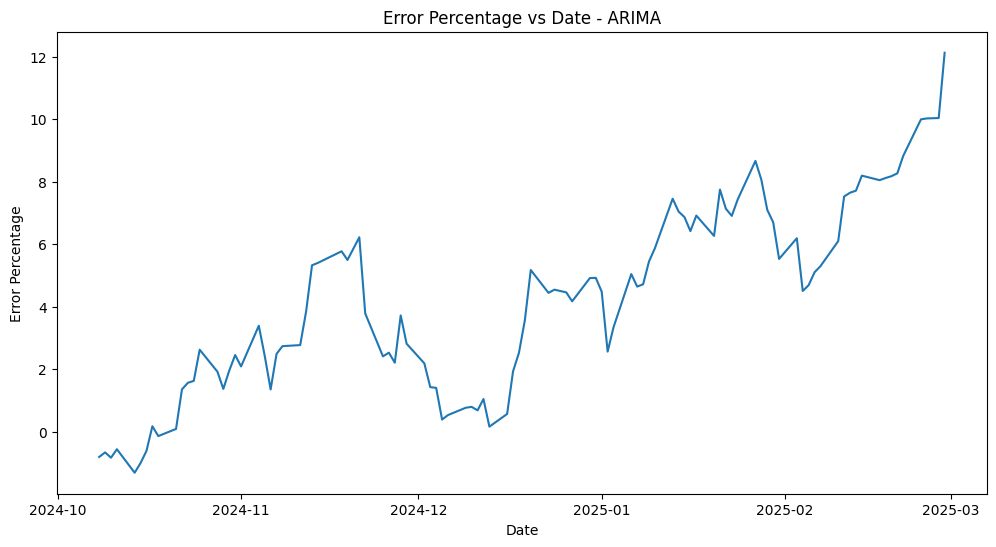

In [16]:
# Plot the Date vs Error Percentage
plt.figure(figsize=(12, 6))
plt.plot(forecast_df['Date'], forecast_df['Error_Percentage'], label="Past 100 Days Error Percentage")
plt.title("Error Percentage vs Date - ARIMA")
plt.xlabel("Date")
plt.ylabel("Error Percentage")

### LSTM Model

In [17]:
# Loading entire data again
data = df[['Close']].dropna()
data.shape

(3722, 1)

In [18]:
# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data.iloc[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 60  # 60 days window
X, y = create_sequences(data, seq_length)

In [19]:
# Create a new DF with created sequence & save into csv
data_seq = pd.DataFrame(X.reshape(X.shape[0], -1),  columns=[f"Day_{i+1}" for i in range(X.shape[1])]
                        , index=data.index[seq_length:], dtype=float)

In [20]:
data_seq.tail()

,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7,Day_8,Day_9,Day_10,...,Day_51,Day_52,Day_53,Day_54,Day_55,Day_56,Day_57,Day_58,Day_59,Day_60
Date,,,,,,,,,,,,,,,,,,,,,
2025-02-21,23914.150391,24131.099609,24276.050781,24457.150391,24467.449219,24708.400391,24677.800781,24619.000000,24610.050781,24641.800781,...,23559.949219,23381.599609,23071.800781,23045.250000,23031.400391,22929.250000,22959.500000,22945.300781,22932.900391,22913.150391
2025-02-24,24131.099609,24276.050781,24457.150391,24467.449219,24708.400391,24677.800781,24619.000000,24610.050781,24641.800781,24548.699219,...,23381.599609,23071.800781,23045.250000,23031.400391,22929.250000,22959.500000,22945.300781,22932.900391,22913.150391,22795.900391
2025-02-25,24276.050781,24457.150391,24467.449219,24708.400391,24677.800781,24619.000000,24610.050781,24641.800781,24548.699219,24768.300781,...,23071.800781,23045.250000,23031.400391,22929.250000,22959.500000,22945.300781,22932.900391,22913.150391,22795.900391,22553.349609
2025-02-27,24457.150391,24467.449219,24708.400391,24677.800781,24619.000000,24610.050781,24641.800781,24548.699219,24768.300781,24668.250000,...,23045.250000,23031.400391,22929.250000,22959.500000,22945.300781,22932.900391,22913.150391,22795.900391,22553.349609,22547.550781
2025-02-28,24467.449219,24708.400391,24677.800781,24619.000000,24610.050781,24641.800781,24548.699219,24768.300781,24668.250000,24336.000000,...,23031.400391,22929.250000,22959.500000,22945.300781,22932.900391,22913.150391,22795.900391,22553.349609,22547.550781,22545.050781


In [21]:
data_seq.shape

(3662, 60)

In [22]:
X_final, y_final = X[:-100], y[:-100]
X_last_100, y_last_100 = X[-100:], y[-100:]
X_final.shape, y_final.shape, X_last_100.shape, y_last_100.shape

((3562, 60, 1), (3562, 1), (100, 60, 1), (100, 1))

In [23]:
# Split data into train, test
train_size = int(0.8 * len(X_final))
X_train, X_test = X_final[:train_size], X_final[train_size:]
y_train, y_test = y_final[:train_size], y_final[train_size:]

# Reshape X_train and X_test to 2D before scaling
X_train_2D = X_train.reshape(X_train.shape[0], -1)  # Reshape to 2D for scaling
X_test_2D = X_test.reshape(X_test.shape[0], -1)    # Reshape to 2D for scaling
X_last_100_2D = X_last_100.reshape(X_last_100.shape[0], -1)

# Data Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train_2D)
X_test_scaled = scaler.transform(X_test_2D)
X_last_100_scaled = scaler.transform(X_last_100_2D)

y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.reshape(-1, 1))
y_last_100_scaled = scaler.transform(y_last_100.reshape(-1, 1))

# Reshape back to original shape
X_train_scaled = X_train_scaled.reshape(X_train.shape)  # Reshape back to (2849, 60, 1)
X_test_scaled = X_test_scaled.reshape(X_test.shape)    # Reshape back to (713, 60, 1)
X_last_100_scaled = X_last_100_scaled.reshape(X_last_100.shape) # Reshape back to (100, 60, 1)

In [24]:
X_test.shape, X_test_2D.shape, X_test_scaled.shape, X_last_100.shape, X_last_100_2D.shape,  X_last_100_scaled.shape

((713, 60, 1), (713, 60), (713, 60, 1), (100, 60, 1), (100, 60), (100, 60, 1))

In [25]:
# Build LSTM Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

model.compile(optimizer="adam", loss="mse")
model.fit(X_train_scaled, y_train_scaled, epochs=20, batch_size=32, validation_data=(X_test_scaled, y_test_scaled))

Epoch 1/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - loss: 0.0281 - val_loss: 0.0020
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - loss: 0.0011 - val_loss: 0.0148
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 0.0014 - val_loss: 0.0152
Epoch 6/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - loss: 0.0014 - val_loss: 0.0022
Epoch 7/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - loss: 8.7895e-04 - val_loss: 0.0021
Epoch 8/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 8.1302e-04 - val_loss: 8.2431e-04
Epoch 9/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - loss: 6.3873e-04 - val_loss: 7.4653e-04
Epoch 10/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 6.2181e-04 - val_loss: 0.0031
Epoch 11/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 6.7822e-04 - val_loss: 0.0014
Epoch 12/20
90/90 ━━━━━━━━━━━━

#### Predict Stock Price of t+1 using LSTM

In [26]:
# Predictions
y_pred = model.predict(X_last_100_scaled)  # X_last_100_scaled now has the correct shape
y_pred_inv = scaler.inverse_transform(y_pred)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


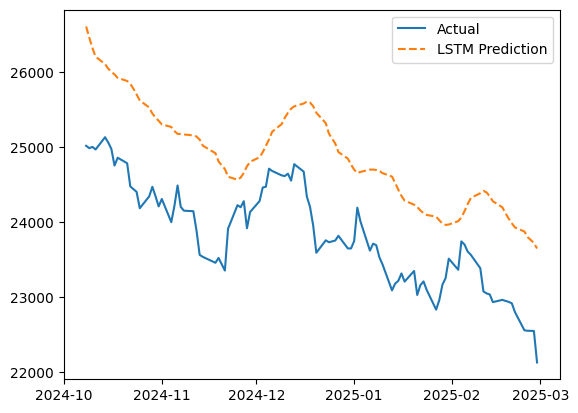

In [27]:
plt.plot(data.index[-100:], y_last_100, label="Actual")
plt.plot(data.index[-100:], y_pred_inv, label="LSTM Prediction", linestyle="dashed")
plt.legend()
plt.show()

#### To Predict t+100 (Next 100 Days) using LSTM

In [28]:
# Use the last available sequence from the test set as input
last_seq = X_test_scaled[-1].astype(np.float32)  # Shape: (60, 1)
future_predictions = []

# Predict next 50 days
for _ in range(100):
    next_pred = model.predict(last_seq.reshape(1, seq_length, 1))  # Predict 1 day ahead
    future_predictions.append(next_pred[0, 0])  # Save prediction

    # Update sequence: Remove first day & append new prediction
    last_seq = np.append(last_seq[1:], next_pred).reshape(seq_length, 1).astype(np.float32)

# Inverse transform predictions to original scale
future_predictions_inv = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Generate date range for future predictions
# future_dates = pd.date_range(start=df.index[-1], periods=51)[1:]
future_dates = data_last_100.index

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━

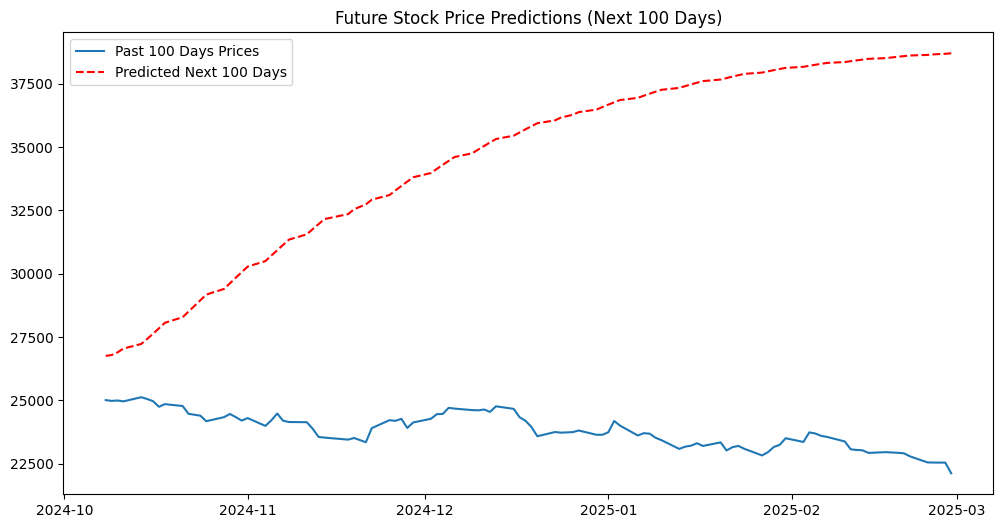

         Date  Predicted_Close  Actual_Close
0  2024-10-08     26760.501953  25013.150391
1  2024-10-09     26792.464844  24981.949219
2  2024-10-10     26898.156250  24998.449219
3  2024-10-11     27049.707031  24964.250000
4  2024-10-14     27229.267578  25127.949219
..        ...              ...           ...
95 2025-02-21     38619.113281  22795.900391
96 2025-02-24     38642.433594  22553.349609
97 2025-02-25     38664.828125  22547.550781
98 2025-02-27     38686.328125  22545.050781
99 2025-02-28     38706.957031  22124.699219

[100 rows x 3 columns]


In [29]:
# Plot Predictions
plt.figure(figsize=(12, 6))
plt.plot(future_dates, y_last_100, label="Past 100 Days Prices")
plt.plot(future_dates, future_predictions_inv, label="Predicted Next 100 Days", linestyle="dashed", color='red')
plt.title("Future Stock Price Predictions (Next 100 Days)")
plt.legend()
plt.show()

# Print Predicted Prices
predicted_prices_df = pd.DataFrame({"Date": future_dates, "Predicted_Close": future_predictions_inv.flatten(), "Actual_Close": y_last_100.flatten()})
print(predicted_prices_df)

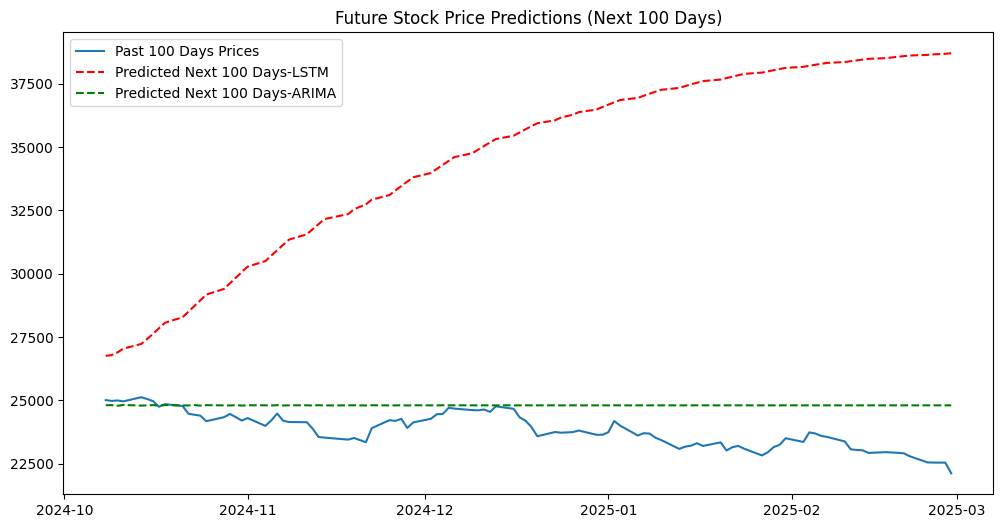

In [30]:
# Plot Both Actual, LSTM, ARIMA predictions wrt Date
plt.figure(figsize=(12, 6))
plt.plot(data.index[-100:], data['Close'].values[-100:], label="Past 100 Days Prices")
plt.plot(future_dates, future_predictions_inv, label="Predicted Next 100 Days-LSTM", linestyle="dashed", color='red')
plt.plot(future_dates, forecast_values, label="Predicted Next 100 Days-ARIMA", linestyle="dashed", color='green')
plt.title("Future Stock Price Predictions (Next 100 Days)")
plt.legend()
plt.show()

In [31]:
# Final Forecast DF
final_forecast_df = pd.DataFrame({"Date": future_dates, "Actual_Close": y_last_100.flatten(),
                                  "Predicted_Close_LSTM": future_predictions_inv.flatten(),
                                  "Predicted_Close_ARIMA": forecast_values})
print(final_forecast_df)

# Save final_forecast_df
final_forecast_df.to_csv("final_forecast_df.csv", index=False)

           Date  Actual_Close  Predicted_Close_LSTM  Predicted_Close_ARIMA
3622 2024-10-08  25013.150391          26760.501953           24810.039051
3623 2024-10-09  24981.949219          26792.464844           24815.901220
3624 2024-10-10  24998.449219          26898.156250           24789.739386
3625 2024-10-11  24964.250000          27049.707031           24823.264416
3626 2024-10-14  25127.949219          27229.267578           24797.307068
...         ...           ...                   ...                    ...
3717 2025-02-21  22795.900391          38619.113281           24806.875091
3718 2025-02-24  22553.349609          38642.433594           24806.437943
3719 2025-02-25  22547.550781          38664.828125           24806.683964
3720 2025-02-27  22545.050781          38686.328125           24806.716995
3721 2025-02-28  22124.699219          38706.957031           24806.443619

[100 rows x 4 columns]


In [32]:
from sklearn.metrics import r2_score

In [33]:
# Evaluation Metrics
def evaluate_model(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    direction_accuracy = np.mean((np.sign(np.diff(y_true)) == np.sign(np.diff(y_pred))).astype(int)) * 100

    # Sharpe Ratio Calculation
    returns = np.diff(y_pred) / y_pred[:-1]
    sharpe_ratio = np.mean(returns) / np.std(returns) if np.std(returns) != 0 else 0

    r_squared = r2_score(y_true, y_pred)

    # Model Accuracy
    model_accuracy = 1 - (mae / np.mean(y_true))

    return {"RMSE": rmse, "MAE": mae, "MAPE": mape, "Directional Accuracy": direction_accuracy, "Sharpe Ratio": sharpe_ratio, "r_squared":r_squared, "Model Accuracy": model_accuracy}


    return {"RMSE": rmse, "MAE": mae, "MAPE": mape, "Directional Accuracy": direction_accuracy, "Sharpe Ratio": sharpe_ratio}

In [34]:
evaluate_model(final_forecast_df["Actual_Close"], final_forecast_df["Predicted_Close_LSTM"]) # LSTM Metrics

{'RMSE': 11543.52479269177,
 'MAE': 10712.44576171875,
 'MAPE': 45.41663005661679,
 'Directional Accuracy': 37.37373737373738,
 'Sharpe Ratio': 1.5084033708183961,
 'r_squared': -281.78641160369136,
 'Model Accuracy': 0.5506112750789416}

In [35]:
evaluate_model(final_forecast_df["Actual_Close"], final_forecast_df["Predicted_Close_ARIMA"]) # ARIMA Metrics

{'RMSE': 1187.3204896594912,
 'MAE': 998.6910594906956,
 'MAPE': 4.270182561171622,
 'Directional Accuracy': 54.54545454545454,
 'Sharpe Ratio': -0.004011500377276839,
 'r_squared': -1.9916968346789785,
 'Model Accuracy': 0.9581047585399791}